# Notebook 02 — Feature Engineering & Regime Detection

In this step, we build the **feature matrix** and infer **market regimes** that capture structural shifts in behavior before modeling.  
The goal is to surface robust, de-leaked signals and stable regime labels for downstream models.

**Main steps:**
1. Load aligned price panel from Notebook 01.
2. Engineer features (target + cross-asset):
   - Momentum/trend (MA/EMA, MACD, RSI/ADX), volatility (realized/ATR), ranges/candlesticks, volume/turnover.
   - Cross-asset spreads, rolling correlations/dispersion; optional macro/sentiment hooks.
3. Clean & standardize:
   - Winsorize/clip outliers, z-score scaling, **correlation pruning**; optional **PCA** to target variance (e.g., 90%).
4. Detect regimes:
   - Try KMeans/GMM/**HMM (sticky)** for `k ∈ {2…4}`; select by silhouette (+ persistence/dwell sanity).
   - Apply smoothing / minimum run-length to reduce flip-flopping.
5. Log diagnostics: timeline plot, regime proportions, median dwell, silhouette/BIC where relevant.
6. Save:
   - Features → `data/processed/{ASSET_KEY}_features.parquet`
   - Regimes → `data/processed/{ASSET_KEY}_regimes.parquet`
   - Merged (features + regimes) → `data/processed/{ASSET_KEY}_features_with_regimes.parquet`
   - Regime meta (method, `k`, silhouette, dwell) → `data/processed/{ASSET_KEY}_regime_meta.json`


## Environment & Paths

In [17]:

import os, sys, json
from pathlib import Path

# Detect Colab
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Mount Drive & set PROJECT_ROOT
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    PROJECT_ROOT = Path("/content/drive/MyDrive/FINAL_PROJECT_MLDL")
else:
    PROJECT_ROOT = Path(".").resolve()

PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)

%cd "$PROJECT_ROOT"

# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
print("SRC_DIR on sys.path:", str(SRC_DIR) in sys.path or str(SRC_DIR) == sys.path[0])

# Folders
CFG_DIR  = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)
print("PROC_DIR:", PROC_DIR)

# Colab deps (idempotent)
if IN_COLAB:
    try:
        import pyarrow, sklearn, yaml  # noqa: F401
    except Exception:
        !pip -q install pyarrow scikit-learn pyyaml


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/FINAL_PROJECT_MLDL
/content/drive/MyDrive/FINAL_PROJECT_MLDL
SRC_DIR on sys.path: True
PROC_DIR: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed


## Load configuration & pick asset

In [18]:

import yaml

cfg_path = CFG_DIR / "base.yaml"
assert cfg_path.exists(), f"Missing config at {cfg_path}"
base = yaml.safe_load(open(cfg_path))

ASSET_KEY = "eurusd"

def asset_file(stem: str) -> Path:
    return PROC_DIR / f"{ASSET_KEY}_{stem}.parquet"


## Load aligned data from Notebook 01

In [19]:

import pandas as pd

aligned_path = asset_file("aligned")
assert aligned_path.exists(), f"Missing {aligned_path}. Run 01_data_prep first."
aligned = pd.read_parquet(aligned_path)
aligned["Date"] = pd.to_datetime(aligned["Date"])
aligned = aligned.sort_values("Date").reset_index(drop=True)
print("Loaded:", aligned_path, "shape=", aligned.shape, "range:", aligned["Date"].min().date(), "→", aligned["Date"].max().date())
aligned.head(3)


Loaded: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_aligned.parquet shape= (3913, 36) range: 2010-01-01 → 2024-12-31


,Date,target_Open,target_High,target_Low,target_Close,target_Volume,dxy_Open,dxy_High,dxy_Low,dxy_Close,...,tnx_Open,tnx_High,tnx_Low,tnx_Close,tnx_Volume,bench_Open,bench_High,bench_Low,bench_Close,bench_Volume
0,2010-01-01,1.432706,1.440196,1.432706,1.438994,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-04,1.431004,1.445191,1.426208,1.442398,0.0,77.930000,78.190002,77.260002,77.529999,...,3.859,3.859,3.808,3.841,0.0,84.791252,85.560913,84.142320,85.515640,118944600.0
2,2010-01-05,1.442710,1.448310,1.435194,1.436596,0.0,77.370003,77.709999,77.089996,77.620003,...,3.790,3.800,3.749,3.755,0.0,85.462809,85.779728,85.153432,85.741997,111579900.0



## Feature Engineering



We create a rich set of cross-asset features capturing returns, volatility, moving averages, and correlations across all instruments.  
These features are cleaned and aligned to ensure consistency, forming the foundation for regime detection in later steps.

### We Apply a Warm-Up Period

Many of the features we compute — such as moving averages, volatility, RSI, and rolling correlations — need a certain amount of past data before they become valid.  
For example:
- A 252-day moving average can only be calculated after 252 days of prices.
- A 60-day rolling correlation needs 60 days of overlapping history between assets.

We also ensure all assets in the dataset have started trading and have aligned data before including a row.  

By combining:
1. **Latest asset start date** (so no asset is missing), and  
2. **Longest rolling window** from any feature,  

we determine a **warm-up period** and drop the early rows.  
This guarantees that every feature in every asset is complete and reliable before moving forward with regime detection and modeling.

In [20]:

from src.features import cross_asset_features
import re

# Detect assets from *_Close columns
close_cols  = [c for c in aligned.columns if isinstance(c, str) and c.endswith("_Close")]
asset_names = sorted({c.rsplit("_", 1)[0] for c in close_cols})

# Build features
X = cross_asset_features(aligned, asset_names)
if "Date" in aligned.columns:
    X.index = aligned.loc[X.index, "Date"]

# Dynamic warm-up: latest asset start + longest window (corr gets extra)
latest_start = max((aligned[f"{a}_Close"].first_valid_index() or 0) for a in asset_names)
nums_all  = []
nums_corr = []
for col in X.columns:
    m = re.search(r"(?:ret|vol|ma|atr|rsi)(\d+)$", col)
    if m: nums_all.append(int(m.group(1)))
    m2 = re.search(r"corr_.*_(\d+)$", col)
    if m2: nums_corr.append(int(m2.group(1)))
max_all  = max(nums_all)  if nums_all  else 0
max_corr = max(nums_corr) if nums_corr else 0
warmup   = max(max_all, latest_start + max_corr)

# Trim + past-only fill, then persist
X = X.iloc[warmup:].ffill().dropna(how="all")
feat_path = asset_file("features")
X_out = X.copy()
X_out["Date"] = X.index if isinstance(X.index, pd.DatetimeIndex) else aligned.loc[X.index, "Date"]
X_out.to_parquet(feat_path, index=False)

print(f"features: {X.shape} | warmup={warmup} | saved → {feat_path}")
display(X.head())


features: (3852, 138) | warmup=61 | saved → /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_features.parquet


,bench_ret1,bench_ret5,bench_vol5,bench_ma5,bench_ret10,bench_vol10,bench_ma10,bench_ret20,bench_vol20,bench_ma20,...,corr_dxy_20,corr_dxy_60,corr_gold_20,corr_gold_60,corr_tnx_20,corr_tnx_60,corr_vix_20,corr_vix_60,corr_wti_20,corr_wti_60
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-29,0.006347,0.006262,0.082637,-0.003069,0.020029,0.080168,-0.005735,0.052848,0.072610,-0.018377,...,-0.949804,-0.850827,0.451669,0.529561,-0.435122,-0.058821,-0.419254,-0.255901,0.578812,0.510533
2010-03-30,0.000682,-0.000085,0.065128,-0.003765,0.012658,0.072999,-0.005162,0.050655,0.072918,-0.016635,...,-0.947129,-0.850933,0.428133,0.532730,-0.426478,-0.075413,-0.388838,-0.257035,0.557085,0.510739
2010-03-31,-0.003407,0.001369,0.058853,-0.000085,0.003260,0.071338,-0.001436,0.046142,0.075707,-0.011067,...,-0.948274,-0.853920,0.442748,0.534234,-0.474911,-0.101520,-0.310638,-0.243188,0.562589,0.515981
2010-04-01,0.006838,0.009859,0.071010,-0.004924,0.010638,0.078115,-0.007165,0.050116,0.077403,-0.015398,...,-0.943836,-0.854424,0.445711,0.542509,-0.527694,-0.087725,-0.331486,-0.245599,0.561438,0.520428
2010-04-02,0.000000,0.010465,0.069759,-0.002852,0.015780,0.070778,-0.005611,0.035318,0.063863,-0.013692,...,-0.919058,-0.843520,0.429454,0.538859,-0.587952,-0.081703,-0.297065,-0.231188,0.544429,0.524092


## Feature EDA

### EDA - Overview (shape, info, describe, missing)

In [21]:

print('Shape:', X.shape)
print('\nInfo:')
_ = X.info()
print('\nDescribe:')
display(X.describe().T)

# Missing values summary
missing_counts = X.isna().sum().sort_values(ascending=False)
missing_counts_nonzero = missing_counts[missing_counts > 0]
print('\nMissing values (non-zero):')
display(missing_counts_nonzero.head(20))

# Simple completeness ratio
completeness = 1.0 - (X.isna().sum() / len(X))
print('\nMedian feature completeness:', float(completeness.median()))


Shape: (3852, 138)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3852 entries, 2010-03-29 to 2024-12-31
Columns: 138 entries, bench_ret1 to corr_wti_60
dtypes: float64(138)
memory usage: 4.1 MB

Describe:


,count,mean,std,min,25%,50%,75%,max
bench_ret1,3852.0,0.000546,0.010575,-0.109424,-0.003473,0.000482,0.005509,0.090603
bench_ret5,3852.0,0.002714,0.022112,-0.179693,-0.006974,0.004202,0.014523,0.173582
bench_vol5,3852.0,0.134218,0.105132,0.006760,0.069138,0.109674,0.168035,1.402256
bench_ma5,3852.0,-0.000878,0.011155,-0.078951,-0.006842,-0.001952,0.003989,0.114490
bench_ret10,3852.0,0.005400,0.029951,-0.232884,-0.007675,0.008141,0.022432,0.187979
...,...,...,...,...,...,...,...,...
corr_tnx_60,3852.0,0.020785,0.149320,-0.613806,-0.080676,0.014433,0.114258,0.432649
corr_vix_20,3852.0,0.000344,0.249631,-0.804631,-0.173891,0.007594,0.179099,0.743311
corr_vix_60,3852.0,-0.000999,0.157580,-0.493205,-0.098591,-0.007112,0.119150,0.419189
corr_wti_20,3852.0,-0.000338,0.245818,-0.725047,-0.166506,0.006117,0.156808,0.749847



Missing values (non-zero):


,0



Median feature completeness: 1.0


### EDA — Distributions & Skewness

Top 10 most positively skewed features:


,0
wti_vol5,23.419101
wti_vol10,17.471970
wti_atr14,14.323084
wti_vol20,12.744092
tnx_vol5,7.522637
wti_vol60,7.520550
tnx_vol10,7.167165
tnx_vol20,6.247070
tnx_atr14,6.133265
tnx_ma20,5.073754


Top 10 most negatively skewed features:


,0
bench_ret10,-1.141413
bench_ret20,-1.201387
bench_macdsig,-1.428615
bench_macd,-1.515545
corr_dxy_60,-1.842322
wti_ret10,-4.056348
wti_ma10,-5.646030
wti_ma5,-12.490223
wti_ret5,-13.114721
wti_ret1,-38.352076


Selected 20 features for EDA sample: ['target_ret5', np.str_('vix_ret20'), np.str_('dxy_ma10'), np.str_('bench_vol5'), np.str_('vix_ret5'), np.str_('tnx_ma60'), np.str_('gold_vol20'), np.str_('wti_ma60'), np.str_('target_vol60'), np.str_('vix_macd'), np.str_('vix_macdsig'), np.str_('bench_macdsig'), np.str_('dxy_bb_pos'), np.str_('target_ret10'), np.str_('gold_macd'), np.str_('corr_wti_60'), np.str_('vix_atr14'), np.str_('vix_ma5'), np.str_('bench_bb_pos'), np.str_('dxy_ret60')]


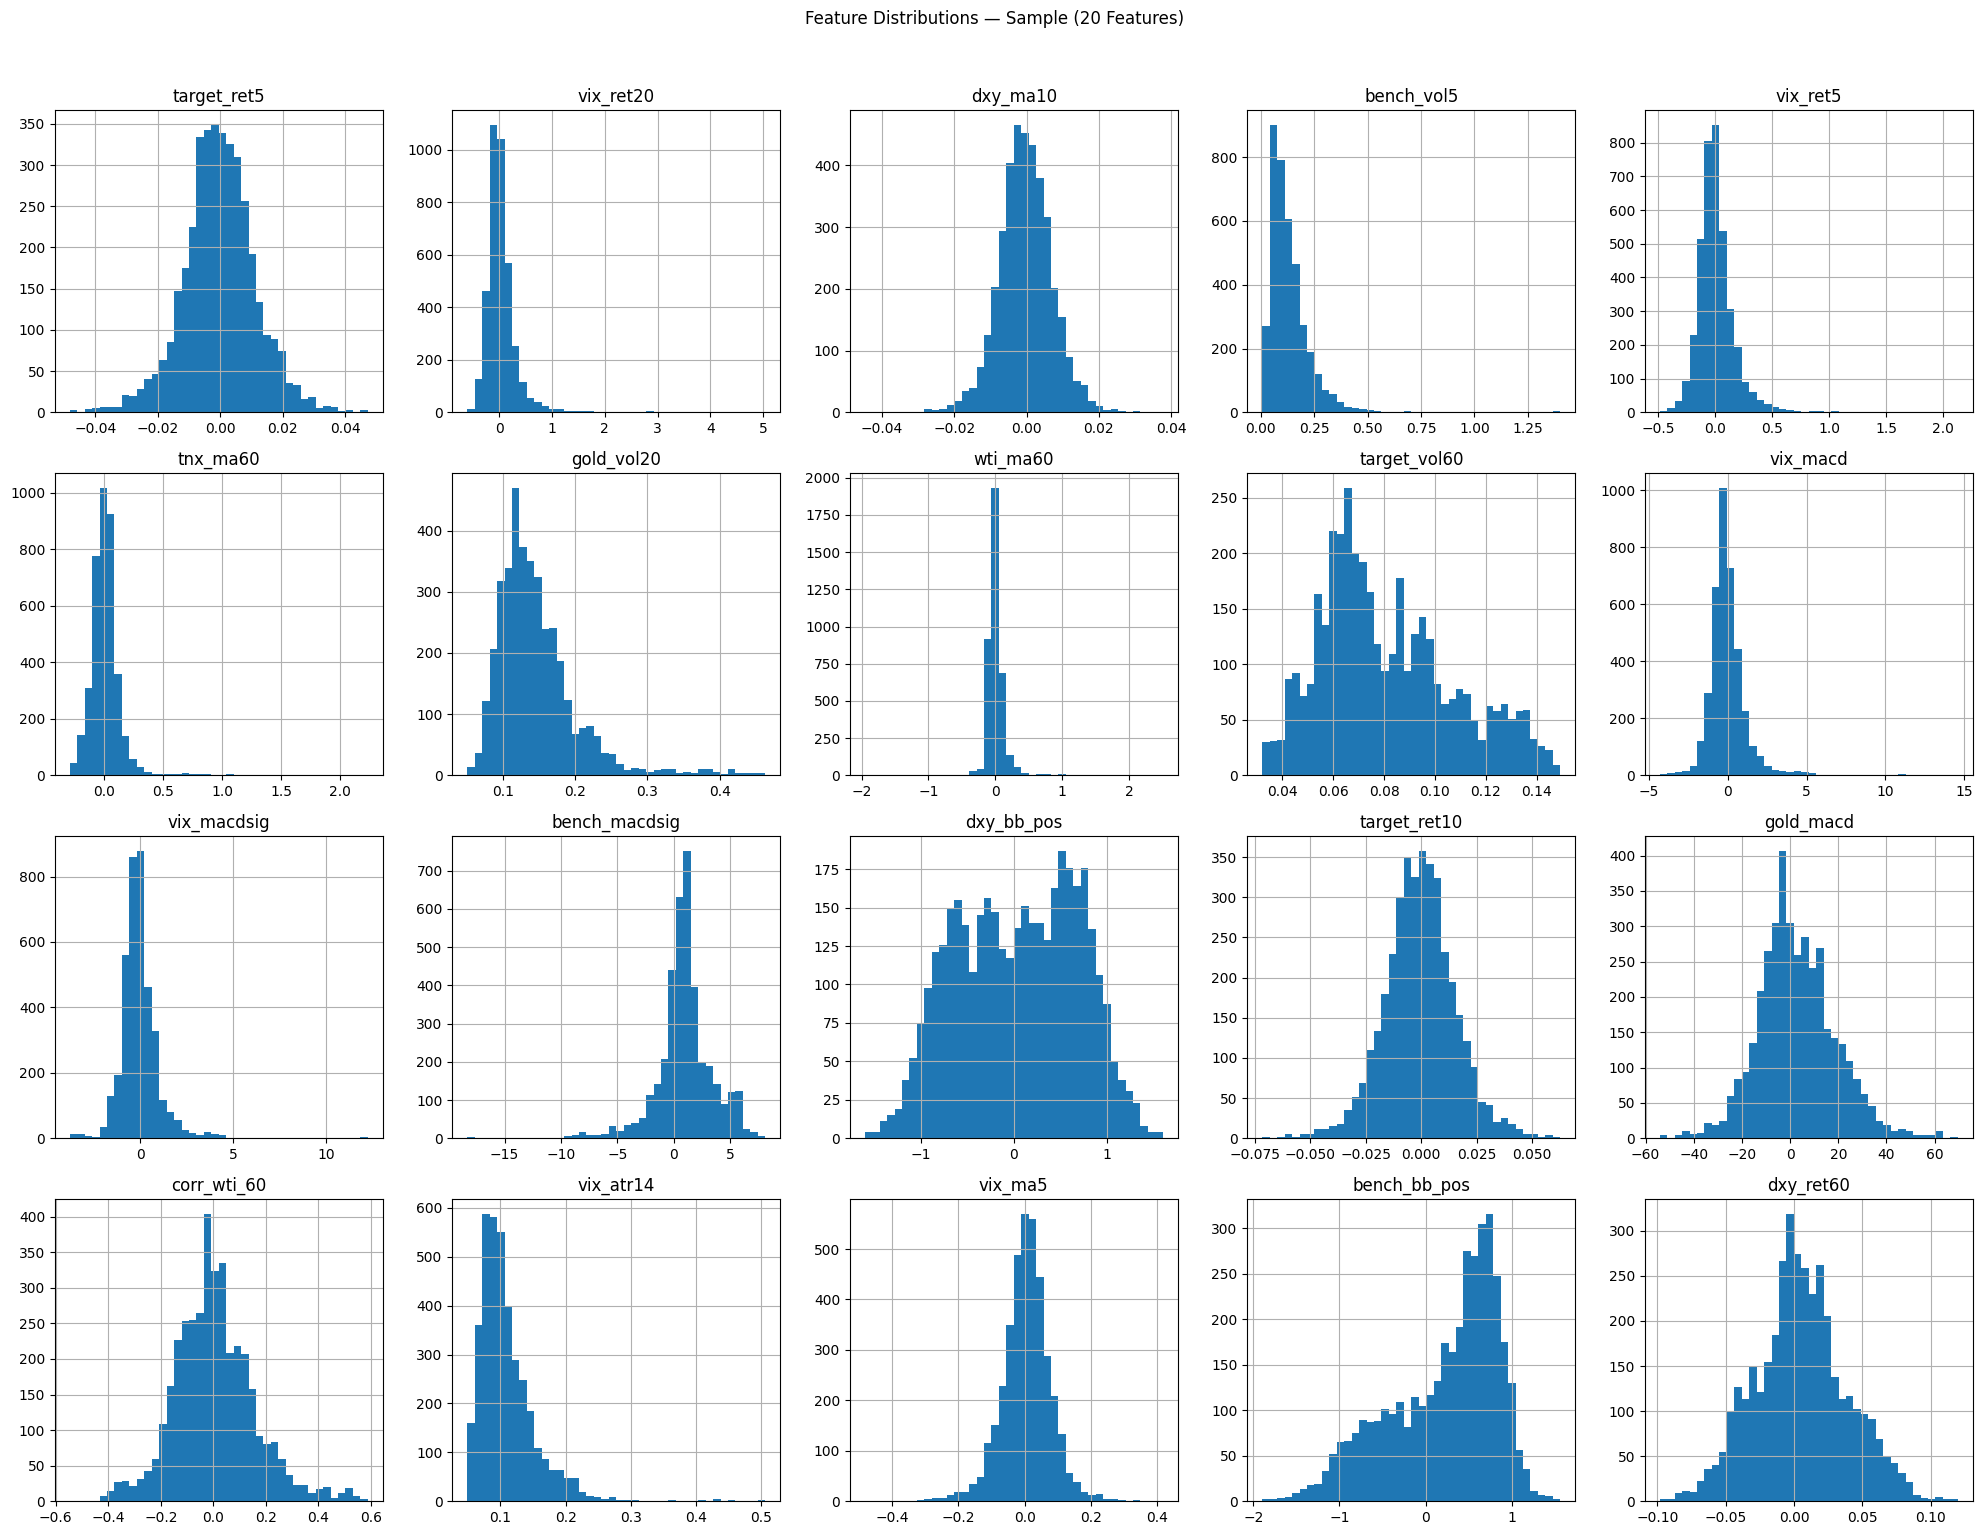

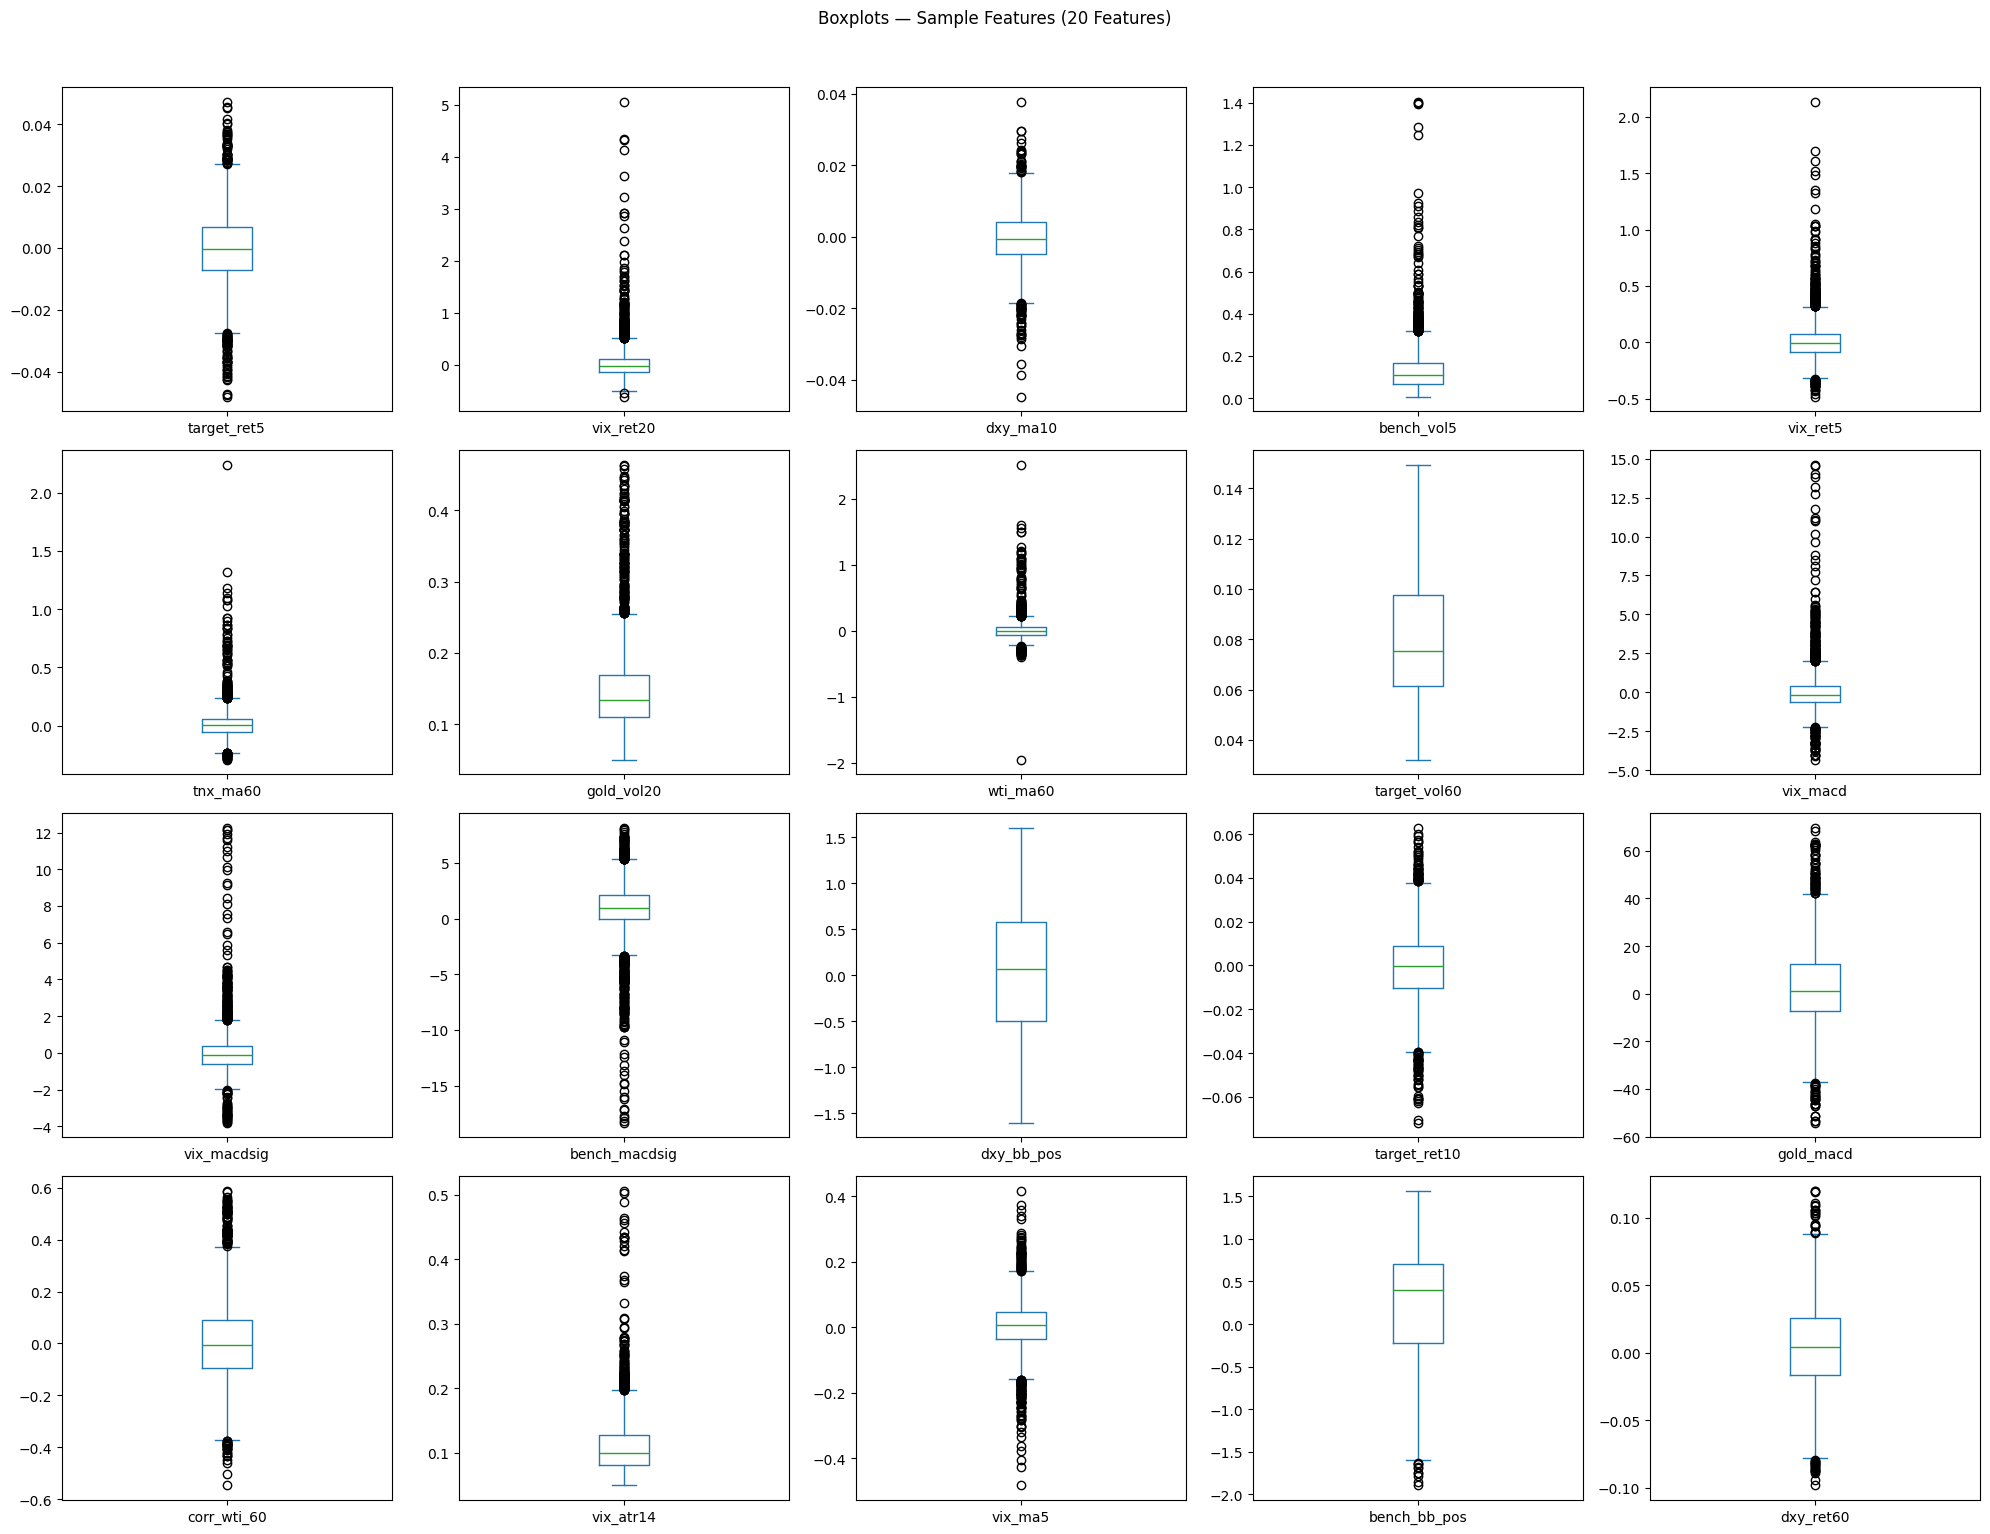

In [22]:

import numpy as np
import matplotlib.pyplot as plt

# Skewness ranking
skew_vals = X.skew(numeric_only=True).sort_values(ascending=False)
print('Top 10 most positively skewed features:')
display(skew_vals.head(10))
print('Top 10 most negatively skewed features:')
display(skew_vals.tail(10))

# Pick a manageable sample of features for plots
# Ensure we include the target 5-day return feature if present
target_feat = "target_ret5"  # adjust if your column name is different
sample_feats = []

if target_feat in X.columns:
    sample_feats.append(target_feat)

# Randomly pick 19 other features excluding the target
other_feats = [c for c in X.columns if c != target_feat]
if len(other_feats) > 0:
    sample_feats.extend(np.random.choice(other_feats, size=min(19, len(other_feats)), replace=False))

feat_sample = sample_feats
print(f"Selected {len(feat_sample)} features for EDA sample: {feat_sample}")

# Histograms — 20 features
axs = X[feat_sample].hist(
    bins=40,
    figsize=(20, 15),    # larger to fit 20 plots
    layout=(4, 5),       # 4 rows × 5 columns
    sharex=False,
    sharey=False
)
plt.suptitle('Feature Distributions — Sample (20 Features)', y=1.02)
plt.tight_layout()
plt.show()

# Boxplots — 20 features
X[feat_sample].plot(
    kind='box',
    subplots=True,
    layout=(4, 5),       # match histogram grid
    figsize=(20, 15),
    sharey=False
)
plt.suptitle('Boxplots — Sample Features (20 Features)', y=1.02)
plt.tight_layout()
plt.show()

### 📊 Distributions & Skewness Analysis

#### 1. Skewness Analysis
- **Most positively skewed features**:  
  Dominated by **WTI volatility measures** (`wti_vol5`, `wti_vol10`, `wti_vol20`, `wti_vol60`) and **Treasury yield volatility/momentum** (`tnx_vol5`, `tnx_vol10`, `tnx_vol20`, `tnx_ma20`).  
  → Long right tails → rare but extreme positive moves.
- **Most negatively skewed features**:  
  Mainly **WTI returns & moving averages** (`wti_ret1`, `wti_ret5`, `wti_ret10`, `wti_ma5`, `wti_ma10`) and some **benchmark/correlation metrics**.  
  → Heavy left tails → sharp downside moves.

#### 2. Distribution Shapes
- Many features (returns, MACD, correlations) ≈ **normal-like**, centered near zero.
- Volatility features are **highly skewed** & heavy-tailed.
- Position indicators (`*_bb_pos`) show **bounded, asymmetric** patterns.

#### 3. Outlier Patterns
- **Boxplots** show:
  - Heavy tails & numerous outliers (esp. volatility & WTI-related).
  - Heteroscedasticity in some features → could affect model stability.

#### 4. Implications for Feature Engineering
- **Transformations**:
  - Log or √ scaling for skewed volatility features.
  - Standardization or robust scaling for heavy-tailed data.
- **Outlier handling**:
  - Winsorization or clipping may help stabilize training.
- **Modeling considerations**:
  - Volatility features may dominate without normalization.
  - Skewness patterns might be regime-dependent → regime-specific preprocessing could be useful.


### EDA — Correlation Analysis by Indicator Type

We group features by their **suffix** (e.g., `_ret5`, `_vol10`) to analyze relationships within each indicator type across assets.  
For each group with ≥ 2 features:

1. **Compact Heatmaps** —  
   Display small side-by-side heatmaps (4×5 grid per page) for a quick visual check of correlation structure.

2. **Redundancy Detection** —  
   On the full group (not truncated for plotting), flag features with an absolute pairwise correlation above **0.9** for potential removal.

3. **Cross-Asset Correlation Summary** —  
   For each group, list the top 3 most correlated feature pairs **across different assets** (ignoring same-asset pairs).

This step helps **identify redundant variables** and understand **how strongly similar indicators move together** across markets before feature pruning.


Found 20 feature groups: ['ret1', 'ret5', 'vol5', 'ma5', 'ret10', 'vol10', 'ma10', 'ret20', 'vol20', 'ma20', 'ret60', 'vol60', 'ma60', 'rsi14', 'macd', 'macdsig', 'atr14', 'pos', '20', '60']


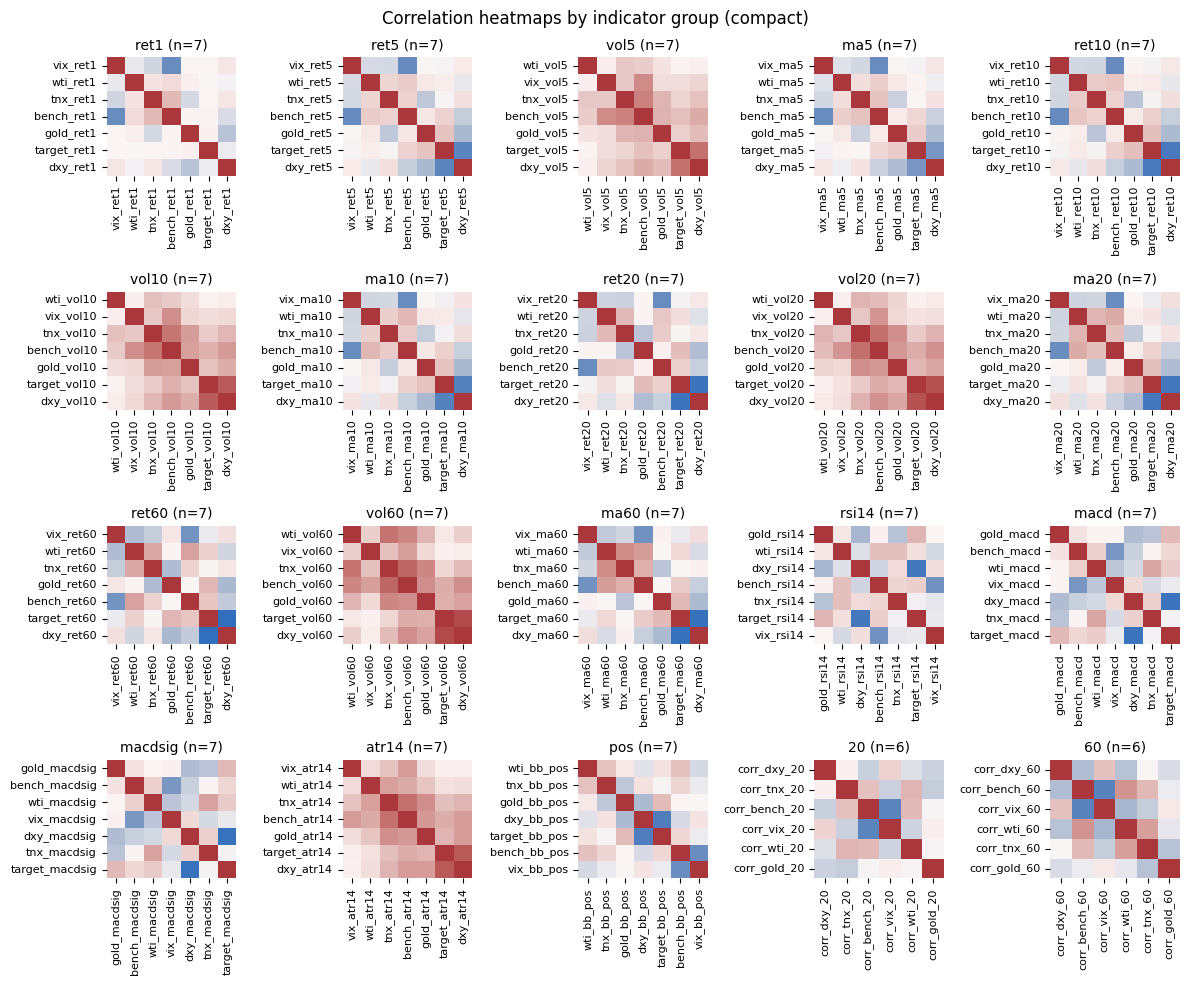

Top 3 cross-asset correlated pairs per indicator group:


,group,rank,asset_1,feature_1,asset_2,feature_2,corr
0,atr14,1,dxy,dxy_atr14,target,target_atr14,0.827
1,atr14,2,bench,bench_atr14,tnx,tnx_atr14,0.704
2,atr14,3,gold,gold_atr14,tnx,tnx_atr14,0.546
3,ma10,1,dxy,dxy_ma10,target,target_ma10,-0.824
4,ma10,2,bench,bench_ma10,vix,vix_ma10,-0.735
5,ma10,3,dxy,dxy_ma10,gold,gold_ma10,-0.418
6,ma20,1,dxy,dxy_ma20,target,target_ma20,-0.896
7,ma20,2,bench,bench_ma20,vix,vix_ma20,-0.732
8,ma20,3,bench,bench_ma20,wti,wti_ma20,0.403
9,ma5,1,bench,bench_ma5,vix,vix_ma5,-0.740


Total redundant features flagged (>0.9 corr): 12


,feature
0,dxy_ma60
1,dxy_macd
2,dxy_macdsig
3,dxy_ret20
4,dxy_ret60
5,dxy_vol60
6,target_ma60
7,target_macd
8,target_macdsig
9,target_ret20


In [23]:

# Group features by suffix (indicator type)
def get_suffix(col): return col.rsplit("_", 1)[-1]
def prefix_of(col):   return col.split("_", 1)[0]

feat_cols = [c for c in X.columns if isinstance(c, str) and c != "Date"]
suffix_groups = {}
for col in feat_cols:
    suf = get_suffix(col)
    suffix_groups.setdefault(suf, []).append(col)

print(f"Found {len(suffix_groups)} feature groups: {list(suffix_groups.keys())}")

# Plot correlation matrices side-by-side
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

GROUPS = [(suf, cols) for suf, cols in suffix_groups.items() if len(cols) >= 2]
MAX_COLS_PER_GROUP = 8      # keep each heatmap compact
GRID_NCOLS = 5
GRID_NROWS = 4              # 6 small mats per "page"
FIGSIZE = (12, 10)

redundant_features = set()

def _top_variance_cols(cols, k=MAX_COLS_PER_GROUP):
    # pick top-variance columns in this group to keep the heatmap legible
    var = X[cols].var(numeric_only=True).sort_values(ascending=False)
    return var.head(min(k, len(var))).index.tolist()

pages = math.ceil(len(GROUPS) / (GRID_NCOLS * GRID_NROWS))
idx = 0
for p in range(pages):
    fig, axes = plt.subplots(GRID_NROWS, GRID_NCOLS, figsize=FIGSIZE)
    axes = np.atleast_2d(axes)
    # prepare a shared color scale
    vmin, vmax = -1, 1
    im0 = None

    for r in range(GRID_NROWS):
        for c in range(GRID_NCOLS):
            if idx >= len(GROUPS):
                axes[r, c].axis("off")
                continue
            suf, cols = GROUPS[idx]
            # compute redundancy on full group (not truncated), but plot a compact version
            corr_full = X[cols].corr()
            # Redundancy: mark features with |ρ| > 0.9 (exclude self)
            mask = (np.abs(corr_full) > 0.9)
            np.fill_diagonal(mask.values, False)
            red_cols = set(corr_full.columns[mask.any(axis=0)])
            redundant_features.update(red_cols)

            # choose compact subset for plotting
            plot_cols = _top_variance_cols(cols)
            corr_small = X[plot_cols].corr()

            ax = axes[r, c]
            im = sns.heatmap(corr_small, vmin=vmin, vmax=vmax, cmap="vlag",
                             cbar=False, annot=False, ax=ax)
            if im0 is None:
                im0 = im
            ax.set_title(f"{suf} (n={len(cols)})", fontsize=10)
            ax.tick_params(labelsize=8)
            idx += 1

    fig.suptitle("Correlation heatmaps by indicator group (compact)", fontsize=12, y=0.98)
    plt.tight_layout()
    plt.show()

# Summary panel: top 3 cross-asset pairs per indicator group
summary_rows = []
for suf, cols in suffix_groups.items():
    if len(cols) < 2:
        continue
    corr = X[cols].corr()
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            c1, c2 = cols[i], cols[j]
            a1, a2 = prefix_of(c1), prefix_of(c2)
            if a1 == a2:
                continue  # only cross-asset pairs
            val = corr.iloc[i, j]
            if pd.isna(val):
                continue
            pairs.append((abs(val), val, c1, c2, a1, a2))
    if not pairs:
        continue
    pairs.sort(key=lambda x: x[0], reverse=True)
    for rank, (_, v, c1, c2, a1, a2) in enumerate(pairs[:3], start=1):
        summary_rows.append({
            "group": suf,
            "rank": rank,
            "asset_1": a1,
            "feature_1": c1,
            "asset_2": a2,
            "feature_2": c2,
            "corr": round(float(v), 3)
        })

summary_df = pd.DataFrame(summary_rows).sort_values(["group", "rank"]).reset_index(drop=True)
print("Top 3 cross-asset correlated pairs per indicator group:")
display(summary_df)

# Redundancy list (> 0.9 by group, based on full corr)
if redundant_features:
    print(f"Total redundant features flagged (>0.9 corr): {len(redundant_features)}")
    display(pd.DataFrame(sorted(redundant_features), columns=["feature"]))
else:
    print("No redundant features found above threshold.")


### 📊 Correlation & Redundancy Analysis

#### 1. Correlation Heatmaps
- **Strong redundancy** appears in several indicator groups:
  - *ma*, *macd*, *macdsig*, *ret*, *vol*, *rsi*.
  - Consistent high |ρ| between *dxy* and *target*.
- Groups like **ATR14** and some shorter-period MAs show **lower redundancy** and more asset diversity.
- The compact grid layout highlights repetitive *target* vs *dxy* patterns (> |0.9|), indicating duplicated signals.

#### 2. Top Cross-Asset Pairs
- **Recurring high correlations**:
  - *dxy* ↔ *target*: negative in returns/momentum, positive in volatility.
  - *bench* ↔ *vix*: often negative in momentum-type indicators.
  - *bench* ↔ *tnx*: positive in volatility-type indicators.
- Many extreme values (|ρ| ≥ 0.9) → strong pattern similarity across assets for a given indicator.

#### 3. Redundant Features (> 0.9 Corr)
- **12 features flagged** — mainly *target* and *dxy* paired with long-term indicators (ma60, macd, ret20/60, vol60).
- Spread across multiple indicator families → redundancy is not isolated.
- Candidate for pruning to reduce dimensionality with minimal information loss.

#### Implications for Feature Selection
1. **Prune duplicates**: especially *target–dxy*, *target–macd*, *target–vol60*.
2. **Regime-aware pruning**: correlations can vary by market regime; avoid over-pruning before regime split.
3. **Preserve diversity**: retain lower-correlation groups (e.g., ATR14, short MA) for independent signal potential.


## Light Preprocessing Before Regime Detection

### What is done here:

- Missing values → median fill.

- Extreme outliers → clipped at 1% & 99%.

- Skew fix → log1p or sqrt for positive-only skewed features.

- Scaling → RobustScaler for stability in clustering.

- No feature removal yet — you still have the full feature set for regime detection.

In [24]:

from sklearn.preprocessing import RobustScaler

# Work on a copy to avoid altering X_raw
X_prep = X.copy()

# Handle missing values (simple fill — clustering can't handle NaNs)
#    Using median fill to reduce distortion from outliers
X_prep = X_prep.fillna(X_prep.median(numeric_only=True))

# Light outlier handling
#    Clip extreme values at 1st and 99th percentile per feature
lower = X_prep.quantile(0.01)
upper = X_prep.quantile(0.99)
X_prep = X_prep.clip(lower=lower, upper=upper, axis=1)

# Minimal skew transformations for clustering stability
#    Apply log1p to strictly positive features with high skewness
#    Apply sqrt for moderately skewed positives
skew_vals = X_prep.skew(numeric_only=True)

for col in skew_vals.index:
    if (X_prep[col] > 0).all():
        if skew_vals[col] > 2:  # very skewed
            X_prep[col] = np.log1p(X_prep[col])
        elif skew_vals[col] > 1:  # moderately skewed
            X_prep[col] = np.sqrt(X_prep[col])

# Scaling — RobustScaler handles outliers better than StandardScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_prep),
    columns=X_prep.columns,
    index=X_prep.index
)

# Keep Date or target columns separately if they exist
if "Date" in X.columns:
    X_scaled.insert(0, "Date", X["Date"])

print("Light preprocessing done — ready for regime detection.")


Light preprocessing done — ready for regime detection.


## Regime detection (K-Means & GMM)

### Regime Detection — What this cell does (and why)

- **Input for clustering:** we take the **scaled feature matrix** (`X_scaled`) and remove `Date`.  
- **Keep only regime-relevant signals:** returns, volatility, trend/momentum (`ret*`, `vol*`, `ma{5,10,20,60}`, `rsi14`, `atr14`, `macd`, `macdsig`).  
  This focuses clustering on broad market *state* rather than niche indicators.

- **Clustering method:** `detect_regimes(...)` (from `src/regimes.py`) runs **KMeans** over `k ∈ {2,3,4}` and selects the best **silhouette** score.  
  *(We set `methods='kmeans'` here; you can enable GMM in that function if you want probabilistic regimes.)*

- **Outputs:**
  - A per-date **`regime_id`** label.
  - A small **meta** dict: chosen method, `k`, and silhouette score.
  - Files saved to `data/processed/`:
    - `{asset}_regimes.parquet` — timeline of regimes.
    - `{asset}_regime_meta.json` — model details.
    - `{asset}_features_with_regimes.parquet` — original features merged with `regime_id` (for notebooks 03/04).

- **Visualization:** quick **regime timeline** (step plot) to eyeball persistence and switches.


#### Regime input picking + pruning + compression

In [25]:

import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

CORR_THR   = 0.95   # correlation pruning threshold
PCA_VAR    = 0.90   # keep 90% variance
MIN_STD    = 1e-12  # drop quasi-constant cols
IMPUTE_MED = True   # median-impute before scaling/PCA

def corr_prune(X: pd.DataFrame, threshold=0.95, method="pearson"):
    """Drop redundant cols when |corr| > threshold; keep the one with higher variance."""
    if X.shape[1] < 2:
        return X, []
    corr = X.corr(method=method).abs()
    upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
    var = X.var()
    to_drop = set()
    for c in upper.columns:
        # neighbors highly correlated with c
        neigh = upper.index[upper[c] > threshold]
        for n in neigh:
            drop = n if var[n] < var[c] else c
            to_drop.add(drop)
    keep_cols = [c for c in X.columns if c not in to_drop]
    return X[keep_cols], sorted(to_drop)

# Start from unscaled features to avoid double-scaling
X_input = X.copy()

# Date handling
if "Date" in X_input.columns:
    date_vec = pd.to_datetime(X_input.pop("Date"))
else:
    date_vec = pd.to_datetime(getattr(X_input.index, "values", pd.RangeIndex(len(X_input))))

# Keep only numeric + regime-relevant families
keep_suffix = re.compile(r"(ret\d+|vol\d+|ma(5|10|20|60)|rsi14|atr14|macd|macdsig)$")
num_cols = X_input.select_dtypes(include=[np.number]).columns
cols_keep = [c for c in num_cols if keep_suffix.search(str(c))]
X_regime_raw = X_input[cols_keep] if len(cols_keep) >= 5 else X_input[num_cols]

# Drop empty/constant columns
const_cols = [c for c in X_regime_raw.columns
              if (X_regime_raw[c].std(skipna=True) < MIN_STD) or (X_regime_raw[c].nunique(dropna=True) <= 1)]
X_regime = X_regime_raw.drop(columns=const_cols) if const_cols else X_regime_raw

# Correlation pruning
X_pruned, dropped_corr = corr_prune(X_regime, threshold=CORR_THR)

# Impute (optional) then scale
X_work = X_pruned.copy()
if IMPUTE_MED:
    X_work = X_work.fillna(X_work.median(numeric_only=True))
scaler = StandardScaler()
Z = scaler.fit_transform(X_work)

# PCA compression to target variance
pca = PCA(n_components=PCA_VAR, svd_solver="full", random_state=42)
Z_pca = pca.fit_transform(Z)
pc_cols = [f"pc{i+1}" for i in range(Z_pca.shape[1])]
X_regime_final = pd.DataFrame(Z_pca, index=X_work.index, columns=pc_cols)

# Summary
print(f"Selected families: {X_regime_raw.shape[1]} → drop const: {len(const_cols)} → "
      f"after corr-prune (>|ρ|>{CORR_THR}): {X_pruned.shape[1]} → "
      f"PCA comps (@{int(PCA_VAR*100)}% var): {X_regime_final.shape[1]}")
print(f"Dropped (corr): {dropped_corr[:10]}{' ...' if len(dropped_corr)>10 else ''}")
print(f"Explained var (first 5): {np.round(pca.explained_variance_ratio_[:5], 3)} | "
      f"Cum: {pca.explained_variance_ratio_.cumsum()[-1]:.3f}")


Selected families: 119 → drop const: 0 → after corr-prune (>|ρ|>0.95): 111 → PCA comps (@90% var): 29
Dropped (corr): ['dxy_ma60', 'dxy_macdsig', 'dxy_ret60', 'target_macd', 'target_macdsig', 'tnx_atr14', 'tnx_macdsig', 'wti_macdsig']
Explained var (first 5): [0.181 0.127 0.099 0.061 0.051] | Cum: 0.905


#### Grid-search HMM regime detection on X, then save features+regimes

In [26]:
 %pip install hmmlearn

In [28]:

from itertools import product
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from hmmlearn.hmm import GaussianHMM
import numpy as np, pandas as pd, time

K_LIST       = [2, 3]
COV_TYPES    = ["diag"]
STICKINESS   = [0.985]
PRIOR_STR    = [200.0]

N_ITER       = 150
TOL          = 1e-2
SIL_SAMPLES  = min(2000, len(Z))
RAND         = 42

# Post-processing (done only once on the best model)
MAJ_WIN      = 7
MIN_RUN      = 7

def _rolling_majority(labels: pd.Series, w: int = 7) -> pd.Series:
    if w <= 1: return labels
    arr = labels.to_numpy(); out = arr.copy(); h = w//2
    for i in range(len(arr)):
        s, e = max(0, i-h), min(len(arr), i+h+1)
        vals, cnts = np.unique(arr[s:e], return_counts=True)
        out[i] = vals[np.argmax(cnts)]
    return pd.Series(out, index=labels.index)

def _enforce_min_run(labels: pd.Series, m: int = 7) -> pd.Series:
    if m <= 1 or labels.empty: return labels
    x = labels.to_numpy().copy(); n=len(x); i=0
    while i<n:
        j=i
        while j<n and x[j]==x[i]: j+=1
        if (j-i)<m:
            if j<n: x[i:j]=x[j]
            elif i>0: x[i:j]=x[i-1]
        i=j
    return pd.Series(x, index=labels.index)

def _init_cov(cov_type, Z, k):
    eps=1e-6
    if cov_type=="diag":
        v = np.var(Z, axis=0)+eps
        return np.tile(v, (k, 1))
    elif cov_type=="tied":
        c = np.cov(Z.T)+eps*np.eye(Z.shape[1])
        return c
    else:
        c = np.cov(Z.T)+eps*np.eye(Z.shape[1])
        return np.tile(c[None,:,:], (k,1,1))

start = time.time()
best = None
for k, cov, st, ps in product(K_LIST, COV_TYPES, STICKINESS, PRIOR_STR):
    km = KMeans(n_clusters=k, n_init="auto", random_state=RAND).fit(Z)
    init_means = km.cluster_centers_

    trans_prior = np.full((k, k), (1.0 - st) / (k - 1))
    np.fill_diagonal(trans_prior, st)
    start_prior = np.full(k, ps / k)

    try:
        hmm = GaussianHMM(
            n_components=k,
            covariance_type=cov,
            n_iter=N_ITER,
            tol=TOL,
            random_state=RAND,
            init_params="st",      # keep our init means/cov
            params="stmc",         # no 'w' for GaussianHMM
            startprob_prior=start_prior,
            transmat_prior=trans_prior * ps,
            verbose=False,
        )
    except TypeError:
        hmm = GaussianHMM(
            n_components=k,
            covariance_type=cov,
            n_iter=N_ITER,
            tol=TOL,
            random_state=RAND,
        )
        hmm.init_params = "st"
        hmm.params = "stmc"

    hmm.means_  = init_means
    hmm.covars_ = _init_cov(cov, Z, k)

    hmm.fit(Z)
    raw_lab = pd.Series(hmm.predict(Z), index=X_work.index)

    # score on a subsample to speed up
    try:
        sil = silhouette_score(Z, raw_lab, sample_size=SIL_SAMPLES, random_state=RAND)
    except Exception:
        sil = np.nan

    if (best is None) or (np.nan_to_num(sil, nan=-1) > np.nan_to_num(best["sil"], nan=-1)):
        best = {"k":k, "cov":cov, "stick":st, "ps":ps, "labels":raw_lab, "sil":sil, "model":hmm}

print(f"Stage 1 done in {time.time()-start:.1f}s | best: k={best['k']}, cov={best['cov']}, "
      f"stick={best['stick']}, prior={best['ps']}, sil={best['sil']:.3f}")

# Smoothing on best labels
labels = best["labels"]
if MAJ_WIN > 1:
    labels = _rolling_majority(labels, w=MAJ_WIN)
labels = _enforce_min_run(labels, m=MIN_RUN)

# Attach and save
features_with_reg = X.copy()
if "Date" not in features_with_reg.columns:
    features_with_reg = features_with_reg.reset_index().rename(columns={"index":"Date"})
features_with_reg["Date"] = pd.to_datetime(features_with_reg["Date"])
features_with_reg["regime_id"] = labels.values

out_path = PROC_DIR / f"{ASSET_KEY}_features_with_regimes.parquet"
Path(PROC_DIR).mkdir(parents=True, exist_ok=True)
features_with_reg.to_parquet(out_path, index=False)
print("Saved:", out_path)


Stage 1 done in 3.1s | best: k=2, cov=diag, stick=0.985, prior=200.0, sil=0.280
Saved: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_features_with_regimes.parquet


## Simple regime timeline (step plot)

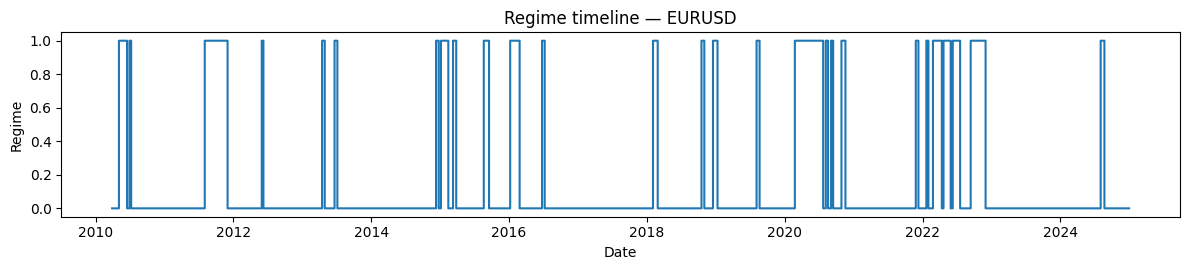

In [31]:

import pandas as pd
import matplotlib.pyplot as plt

reg_path = PROC_DIR / f"{ASSET_KEY}_features_with_regimes.parquet"
df = pd.read_parquet(reg_path, columns=["Date", "regime_id"]).dropna().sort_values("Date")
df["Date"] = pd.to_datetime(df["Date"])
reg = df["regime_id"].astype(int)

plt.figure(figsize=(12, 2.8))
plt.step(df["Date"], reg, where="post")
plt.ylabel("Regime"); plt.xlabel("Date")
plt.title(f"Regime timeline — {ASSET_KEY.upper()}")
plt.tight_layout(); plt.show()


## Feature Pruning per Regime (RandomForest)

In [32]:
import re, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from src.regimes import detect_regimes

# Parameters
TOP_PCT   = 0.30        # top 30% features (per regime)
MAX_KEEP  = 40
MIN_KEEP  = 8
N_SPLITS  = 5
N_TREES   = 400
MIN_ROWS_PER_REGIME = 400

def ensure_date(df: pd.DataFrame, name="Date") -> pd.DataFrame:
    out = df.copy()
    if name not in out.columns:
        out = out.reset_index().rename(columns={"index": name})
    out[name] = pd.to_datetime(out[name])
    # drop duplicate cols if any
    if out.columns.duplicated().any():
        out = out.loc[:, ~out.columns.duplicated()]
    return out

def build_target_from_aligned(aligned_path: Path) -> pd.DataFrame:
    adf = ensure_date(pd.read_parquet(aligned_path))
    tgt = [c for c in adf.columns if isinstance(c,str) and c.startswith("target_") and c.endswith("_Close")]
    if not tgt: tgt = [c for c in adf.columns if c == "target_Close"]
    assert tgt, "target_Close not found in aligned data"
    col = tgt[0]
    adf = adf.sort_values("Date").reset_index(drop=True)
    adf["ret1"]   = adf[col].pct_change()
    adf["y_next"] = np.sign(adf["ret1"].shift(-1)).replace({-1:0, 1:1}).astype("Int64")
    return adf[["Date","y_next"]].dropna()

def pick_regime_inputs(df: pd.DataFrame) -> pd.DataFrame:
    # numeric only, keep common regime families
    keep_suffix = re.compile(r"(ret\d+|vol\d+|ma(5|10|20|60)|rsi14|atr14|macd|macdsig)$")
    df = df.select_dtypes(include=[np.number])
    cols = [c for c in df.columns if keep_suffix.search(str(c))]
    return df[cols] if len(cols) >= 5 else df

def run_detect_wrapped(Xreg: pd.DataFrame):
    # Prefer tuple API; fall back to legacy signature if needed
    try:
        return detect_regimes(
            Xreg, methods=("hmm","kmeans","gmm"),
            k_list=(2,3,4), smooth_window=7, min_run=7, random_state=42
        )
    except TypeError:
        return detect_regimes(
            Xreg, methods="hmm|kmeans|gmm",
            k_range=(2,3,4), min_regime_len=7
        )

# Load Regimes
df_regimes = pd.read_parquet(reg_path)

print("Regime mix:", df_regimes["regime_id"].value_counts(normalize=True).round(3).to_dict())

# Target
y_frame = build_target_from_aligned(asset_file("aligned"))

# Join features + regimes + target
feat_with_date = ensure_date(X if 'X' in globals() else X_scaled)
Z = (feat_with_date
     .merge(df_regimes[["Date","regime_id"]], on="Date", how="inner")
     .merge(y_frame,                          on="Date", how="inner")
     .dropna(subset=["y_next"])
     .sort_values("Date")
     .reset_index(drop=True))

print("Pruning dataset:", Z.shape, "| regimes:", sorted(Z["regime_id"].unique()))

# Per-regime RF pruning
kept_by_regime, imp_tables = {}, {}
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

for rid, grp in Z.groupby("regime_id"):
    grp = grp.sort_values("Date").reset_index(drop=True)
    if len(grp) < max(MIN_ROWS_PER_REGIME, N_SPLITS * 20):
        print(f"⚠️ Regime {rid}: too few rows ({len(grp)}), skipping.")
        continue

    y = grp["y_next"].astype(int).values
    Xr = grp.drop(columns=["Date","regime_id","y_next"]).select_dtypes(include=[np.number])
    cols = Xr.columns.tolist()
    if not cols:
        print(f"⚠️ Regime {rid}: no numeric features, skipping.")
        continue

    fold_imps = []
    for tr, va in tscv.split(Xr):
        clf = RandomForestClassifier(
            n_estimators=N_TREES, min_samples_leaf=5, max_depth=None,
            class_weight="balanced_subsample", random_state=42, n_jobs=-1
        )
        clf.fit(Xr.iloc[tr], y[tr])
        fold_imps.append(pd.Series(clf.feature_importances_, index=cols))

    imps = pd.concat(fold_imps, axis=1).mean(axis=1).sort_values(ascending=False)
    k = max(MIN_KEEP, min(int(len(imps) * TOP_PCT), MAX_KEEP))
    kept = imps.head(k).index.tolist()

    kept_by_regime[int(rid)] = kept
    imp_tables[int(rid)] = imps

    pruned = grp[["Date","regime_id"] + kept]
    out_pq = PROC_DIR / f"{ASSET_KEY}_features_pruned_regime{int(rid)}.parquet"
    pruned.to_parquet(out_pq, index=False)
    print(f"Regime {rid}: kept {k}/{len(cols)} → saved {out_pq.name}")

# Save artifacts
for rid, imps in imp_tables.items():
    imps.to_csv(PROC_DIR / f"{ASSET_KEY}_rf_importance_regime{rid}.csv", header=["importance"])
with open(PROC_DIR / f"{ASSET_KEY}_rf_kept_features.json", "w") as f:
    json.dump(kept_by_regime, f, indent=2)

print("Kept feature lists →", PROC_DIR / f"{ASSET_KEY}_rf_kept_features.json")


Regime mix: {0: 0.834, 1: 0.166}
Pruning dataset: (3851, 141) | regimes: [np.int64(0), np.int64(1)]
Regime 0: kept 40/138 → saved eurusd_features_pruned_regime0.parquet
Regime 1: kept 40/138 → saved eurusd_features_pruned_regime1.parquet
Kept feature lists → /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_rf_kept_features.json
